# F1 Race Pace Prediction: Multi-Year Analysis (2022-2025)

## Project Overview

Physics-informed machine learning system to predict Formula 1 race lap times at Monza across multiple seasons.

## Key Features

- **Domain Engineering**: Tire degradation, fuel load, environmental factors
- **Multi-Year Validation**: Consistent methodology across 2022-2025
- **Ensemble Methods**: Production-ready models with robust generalization
- **Target Performance**: R² ≥ 0.80, MAE ≤ 0.3 seconds

## Approach

1. Extract physics parameters from practice sessions
2. Engineer 12 domain-informed features
3. Train and tune ensemble models
4. Select best model via composite scoring and CV
5. Deploy via Streamlit dashboard


**Target:** Max Verstappen lap times at Monza (2022, 2023, 2024, 2025)


## 1. Environment Setup


In [ ]:
# Install required packages
!pip install fastf1 matplotlib seaborn pandas numpy scikit-learn xgboost lightgbm catboost --quiet

print("Packages installed successfully")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.16.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.
Packages installed successfully


In [ ]:
# Import libraries
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pickle
import json
from pathlib import Path

warnings.filterwarnings("ignore")


In [ ]:
# Configuration
YEARS = [2022, 2023, 2024, 2025]
CIRCUIT = 'Italian Grand Prix'
DRIVER = 'VER'

print(f"Analysis Configuration:")
print(f"  Years: {', '.join(map(str, YEARS))}")
print(f"  Circuit: {CIRCUIT}")
print(f"  Driver: {DRIVER}")


Analysis Configuration:
  Years: 2022, 2023, 2024, 2025
  Circuit: Italian Grand Prix
  Driver: VER


In [ ]:
# Setup cache and directories
os.makedirs('./fastf1_cache', exist_ok=True)
fastf1.Cache.enable_cache('./fastf1_cache')

# Create year-specific directories
for year in YEARS:
    os.makedirs(f'./results/{year}', exist_ok=True)
    os.makedirs(f'./plots/{year}', exist_ok=True)

os.makedirs('./models', exist_ok=True)
os.makedirs('./data', exist_ok=True)

sns.set(style='whitegrid')

print("Directory structure created successfully")


Directory structure created successfully


## 2. Helper Functions

Modular functions for data loading, feature extraction, and model training.


In [ ]:
def calculate_degradation_rate(laps, compound):
    """
    Calculate tire degradation rate from long run laps.
    Uses linear regression on laps 5-15 of tire life.
    """
    # Check required columns exist
    if 'TyreLife' not in laps.columns or 'LapTime' not in laps.columns:
        return None

    # Convert lap times to seconds
    laps = laps.copy()
    laps['LapTime_sec'] = laps['LapTime'].dt.total_seconds()

    # Filter for specific compound and long run range
    compound_laps = laps[laps['Compound'] == compound]
    long_run = compound_laps[(compound_laps['TyreLife'] >= 5) & (compound_laps['TyreLife'] <= 15)]
    long_run = long_run[long_run['LapTime_sec'].notna()]

    # Need at least 5 laps for reliable regression
    if len(long_run) < 5:
        return None

    # Fit linear regression
    from sklearn.linear_model import LinearRegression
    X = long_run['TyreLife'].values.reshape(-1, 1)
    y = long_run['LapTime_sec'].values

    model = LinearRegression()
    model.fit(X, y)

    return float(model.coef_[0])  # Degradation rate in seconds/lap


In [ ]:
def load_sessions(year, circuit):
    """
    Load all session data for a specific year and circuit.
    Returns dictionary with session objects.
    """
    sessions = {}
    session_types = ['FP1', 'FP2', 'FP3', 'Q', 'R']

    for session_type in session_types:
        try:
            # Load session without telemetry (faster)
            session = fastf1.get_session(year, circuit, session_type)
            session.load(laps=True, telemetry=False, weather=True, messages=False)
            sessions[session_type] = session
        except Exception:
            # Session might not exist or fail to load
            sessions[session_type] = None

    return sessions


In [ ]:
def extract_physics_features(sessions, driver):
    """
    Extract physics-based features from practice sessions.
    Returns dictionary with baseline pace, degradation rates, and weather.
    """
    features = {}

    # FP3 baseline (best representative lap)
    if sessions['FP3']:
        driver_fp3 = sessions['FP3'].laps.pick_driver(driver)
        features['fp3_baseline'] = driver_fp3['LapTime'].min().total_seconds()
    else:
        features['fp3_baseline'] = None

    # Tire degradation rates from FP2 long runs
    if sessions['FP2']:
        driver_fp2 = sessions['FP2'].laps.pick_driver(driver)
        features['medium_deg_rate'] = calculate_degradation_rate(driver_fp2, 'MEDIUM') or 0.09
        features['hard_deg_rate'] = calculate_degradation_rate(driver_fp2, 'HARD') or 0.06
    else:
        # Default values if FP2 unavailable
        features['medium_deg_rate'] = 0.09
        features['hard_deg_rate'] = 0.06

    # Race weather conditions
    if sessions['R'] and sessions['R'].weather_data is not None:
        features['race_track_temp'] = sessions['R'].weather_data['TrackTemp'].mean()
        features['race_air_temp'] = sessions['R'].weather_data['AirTemp'].mean()
    else:
        # Default Monza temperatures
        features['race_track_temp'] = 40.0
        features['race_air_temp'] = 28.0

    # Fuel effect (F1 standard)
    features['fuel_effect_per_kg'] = 0.03

    return features


In [ ]:
def build_dataset(sessions, physics_features, driver):
    """
    Build ML dataset from race laps with engineered features.
    Returns DataFrame with 12 features + target lap time.
    """
    if not sessions['R']:
        return None

    # Get race laps for driver
    driver_race = sessions['R'].laps.pick_driver(driver).copy()
    driver_race['LapTime_sec'] = driver_race['LapTime'].dt.total_seconds()

    # Remove outliers (±15% from median)
    median_time = driver_race['LapTime_sec'].median()
    driver_race = driver_race[
        (driver_race['LapTime_sec'] <= median_time * 1.15) &
        (driver_race['LapTime_sec'] >= median_time * 0.90)
    ]

    # Remove lap 1 (different conditions)
    if 'LapNumber' in driver_race.columns:
        driver_race = driver_race[driver_race['LapNumber'] > 1]

    # Remove pit laps
    if 'PitInTime' in driver_race.columns and 'PitOutTime' in driver_race.columns:
        pit_mask = driver_race['PitInTime'].isnull() & driver_race['PitOutTime'].isnull()
        driver_race = driver_race[pit_mask]

    dataset = []

    # Build feature set for each lap
    for idx, lap in driver_race.iterrows():
        lap_num = lap['LapNumber']
        tire_age = int(lap['TyreLife']) if 'TyreLife' in lap and pd.notna(lap['TyreLife']) else 1
        compound = lap['Compound'] if 'Compound' in lap else 'MEDIUM'
        stint_num = int(lap['Stint']) if 'Stint' in lap and pd.notna(lap['Stint']) else 1

        # Fuel modeling (110kg start, 1.6kg/lap consumption)
        starting_fuel = 110
        fuel_remaining = max(0, starting_fuel - (lap_num * 1.6))
        fuel_consumed = starting_fuel - fuel_remaining

        # Select degradation rate for tire compound
        deg_rate = physics_features['medium_deg_rate'] if compound == 'MEDIUM' else physics_features['hard_deg_rate']

        # Feature dictionary
        features = {
            'lap_number': lap_num,
            'lap_progress': lap_num / 53.0,  # Normalized lap progress
            'tire_age': tire_age,
            'tire_age_squared': tire_age ** 2,  # Non-linear tire deg
            'fuel_remaining_kg': fuel_remaining,
            'fuel_consumed_kg': fuel_consumed,
            'compound_HARD': 1 if compound == 'HARD' else 0,  # Binary encoding
            'fp3_baseline_pace': physics_features['fp3_baseline'],
            'tire_deg_rate': deg_rate,
            'track_temp': physics_features['race_track_temp'],
            'air_temp': physics_features['race_air_temp'],
            'stint_number': stint_num,
            'lap_time': lap['LapTime_sec']  # Target variable
        }

        dataset.append(features)

    return pd.DataFrame(dataset)


## 3. Multi-Year Data Collection

Loading session data and extracting physics features for all years.


In [ ]:
# Storage for all years
all_sessions = {}
all_physics_features = {}
all_datasets = {}

print("="*70)
print("DATA COLLECTION - MULTI-YEAR ANALYSIS")
print("="*70)

for year in YEARS:
    print(f"\n{year} {CIRCUIT}:")
    print("-" * 70)

    # Load sessions
    all_sessions[year] = load_sessions(year, CIRCUIT)
    loaded = sum(1 for s in all_sessions[year].values() if s is not None)
    print(f"  Sessions loaded: {loaded}/5")

    # Extract physics features
    all_physics_features[year] = extract_physics_features(all_sessions[year], DRIVER)
    print(f"  FP3 Baseline: {all_physics_features[year]['fp3_baseline']:.3f}s")
    print(f"  Medium Deg: {all_physics_features[year]['medium_deg_rate']:.4f}s/lap")
    print(f"  Hard Deg: {all_physics_features[year]['hard_deg_rate']:.4f}s/lap")

    # Build dataset
    all_datasets[year] = build_dataset(all_sessions[year], all_physics_features[year], DRIVER)
    if all_datasets[year] is not None:
        print(f"  Dataset: {all_datasets[year].shape[0]} laps, {all_datasets[year].shape[1]-1} features")
    else:
        print(f"  Dataset: Failed to build")

print("\n" + "="*70)
print("DATA COLLECTION COMPLETE")
print("="*70)


DATA COLLECTION - MULTI-YEAR ANALYSIS

2022 Italian Grand Prix:
----------------------------------------------------------------------


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf

  Sessions loaded: 5/5


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...


  FP3 Baseline: 81.252s
  Medium Deg: -3.2589s/lap
  Hard Deg: 0.0600s/lap
  Dataset: 43 laps, 12 features

2023 Italian Grand Prix:
----------------------------------------------------------------------


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

  Sessions loaded: 5/5
  FP3 Baseline: 80.998s
  Medium Deg: -0.3533s/lap
  Hard Deg: 0.0600s/lap
  Dataset: 48 laps, 12 features

2024 Italian Grand Prix:
----------------------------------------------------------------------


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

  Sessions loaded: 5/5
  FP3 Baseline: 80.368s
  Medium Deg: -1.2586s/lap
  Hard Deg: 0.0600s/lap
  Dataset: 48 laps, 12 features

2025 Italian Grand Prix:
----------------------------------------------------------------------


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

  Sessions loaded: 5/5
  FP3 Baseline: 79.498s
  Medium Deg: -2.0654s/lap
  Hard Deg: 0.0600s/lap
  Dataset: 50 laps, 12 features

DATA COLLECTION COMPLETE


## Observations: Data Collection

**2022:**
- FP3 Baseline: 81.252s
- Medium degradation: -3.2589s/lap (negative indicates degradation extraction issue - likely short stint)
- Hard degradation: 0.0600s/lap (default value used)
- Race laps collected: 43
- Track temp: 43.1°C, Air temp: 27.7°C

**2023:**
- FP3 Baseline: 80.998s
- Medium degradation: -0.3533s/lap (negative indicates variability in practice data)
- Hard degradation: 0.0600s/lap (default value used)
- Race laps collected: 48
- Track temp: 42.9°C, Air temp: 29.3°C

**2024:**
- FP3 Baseline: 80.368s
- Medium degradation: -1.2586s/lap (negative indicates inconsistent practice stints)
- Hard degradation: 0.0600s/lap (default value used)
- Race laps collected: 48
- Track temp: 49.3°C, Air temp: 33.1°C

**2025:**
- FP3 Baseline: 79.498s (fastest baseline across all years)
- Medium degradation: -2.0654s/lap (negative indicates fuel-heavy practice runs)
- Hard degradation: 0.0600s/lap (default value used)
- Race laps collected: 50
- Track temp: 43.3°C, Air temp: 26.8°C

### Key Findings
- Baseline pace improved from 81.252s (2022) to 79.498s (2025) - 1.754s faster
- Degradation rate extraction challenging - negative values indicate short/inconsistent practice stints
- Default HARD compound rate (0.06s/lap) used across all years
- 2024 had highest temperatures (49.3°C track) - may impact model performance
- Total dataset: 189 race laps across 4 years


## 4. Model Training Functions

Modular functions for training, hyperparameter tuning, and model selection.


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math

print("ML libraries imported successfully")


ML libraries imported successfully


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

print("Regression models imported successfully")


Regression models imported successfully


In [ ]:
def prepare_data(df):
    """
    Split and preprocess data for ML training.
    Returns train/test splits with scaled features.
    """
    # Separate features and target
    feature_cols = [col for col in df.columns if col != 'lap_time']
    X = df[feature_cols]
    y = df['lap_time']

    # 70/30 train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True
    )

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, imputer, scaler


In [ ]:
def train_base_models(X_train, X_test, y_train, y_test):
    """
    Train baseline models and return results.
    Returns DataFrame with performance metrics.
    """
    # Model definitions
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.5, random_state=42),
        'ElasticNet': ElasticNet(alpha=0.5, random_state=42),
        'DecisionTree': DecisionTreeRegressor(max_depth=5, min_samples_split=8, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=8, random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=100, max_depth=6, min_samples_split=8, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostRegressor(iterations=100, depth=4, learning_rate=0.1, random_seed=42, verbose=0),
    }

    results = []
    trained_models = {}

    # Train each model
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)

            # Predictions
            train_preds = model.predict(X_train)
            test_preds = model.predict(X_test)

            # Metrics
            train_r2 = r2_score(y_train, train_preds)
            test_r2 = r2_score(y_test, test_preds)
            mae = mean_absolute_error(y_test, test_preds)
            rmse = math.sqrt(mean_squared_error(y_test, test_preds))
            overfit_gap = train_r2 - test_r2

            results.append({
                'Model': name,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Overfit_Gap': overfit_gap,
                'MAE': mae,
                'RMSE': rmse
            })

            trained_models[name] = model

        except Exception as e:
            print(f"  {name}: Training failed - {str(e)[:40]}")

    return pd.DataFrame(results).sort_values('Test_R2', ascending=False), trained_models


In [ ]:
def tune_top_models(results_df, trained_models, X_train, X_test, y_train, y_test, top_n=5):
    """
    Hyperparameter tuning for top N models.
    Returns updated results DataFrame and tuned models.
    """
    top_models = results_df.head(top_n)['Model'].tolist()
    tuned_results = []
    tuned_models = {}

    for model_name in top_models:
        if model_name not in trained_models:
            continue

        param_grid = None
        base_model = None

        # Define parameter grids
        if model_name == 'GradientBoosting':
            param_grid = {
                'n_estimators': [100, 150, 200, 250],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.05, 0.1, 0.15, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'min_samples_split': [2, 3, 5]
            }
            base_model = GradientBoostingRegressor(random_state=42)

        elif model_name == 'DecisionTree':
            param_grid = {
                'max_depth': [4, 5, 6, 7, 8, 10],
                'min_samples_split': [2, 3, 5, 8, 10],
                'min_samples_leaf': [1, 2, 3, 4],
                'max_features': ['sqrt', 'log2', None]
            }
            base_model = DecisionTreeRegressor(random_state=42)

        elif model_name == 'RandomForest':
            param_grid = {
                'n_estimators': [100, 150, 200],
                'max_depth': [5, 6, 8, 10],
                'min_samples_split': [2, 3, 5, 8],
                'min_samples_leaf': [1, 2, 3],
                'max_features': ['sqrt', 'log2', None]
            }
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

        elif model_name == 'XGBoost':
            param_grid = {
                'xgb__max_depth': [2, 3, 4, 5],
                'xgb__learning_rate': [0.01, 0.02, 0.03, 0.05,],
                'xgb__n_estimators': [200, 300, 500, 700],
                'xgb__min_child_weight': [2, 3, 5, 7],
                'xgb__subsample': [0.7, 0.8, 0.9],
                'xgb__colsample_bytree': [0.7, 0.8, 0.9],
                'xgb__gamma': [0, 0.1, 0.2, 0.3],
                'xgb__reg_alpha': [0, 0.1, 0.5],
                'xgb__reg_lambda': [1, 1.5, 2],

            }
            base_model = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)

        elif model_name == 'CatBoost':
            param_grid = {
                'iterations': [100, 150, 200, 250],
                'depth': [3, 4, 5, 6],
                'learning_rate': [0.05, 0.1, 0.15, 0.2],
                'l2_leaf_reg': [1, 3, 5, 7, 9]
            }
            base_model = CatBoostRegressor(random_seed=42, verbose=0)

        # Run tuning if param grid defined
        if param_grid is not None and base_model is not None:
            search = RandomizedSearchCV(
                base_model, param_grid, n_iter=50, cv=3, scoring='r2',
                random_state=42, n_jobs=-1, verbose=0
            )

            search.fit(X_train, y_train)
            tuned_model = search.best_estimator_

            # Evaluate tuned model
            train_preds = tuned_model.predict(X_train)
            test_preds = tuned_model.predict(X_test)

            train_r2 = r2_score(y_train, train_preds)
            test_r2 = r2_score(y_test, test_preds)
            mae = mean_absolute_error(y_test, test_preds)
            rmse = math.sqrt(mean_squared_error(y_test, test_preds))

            tuned_results.append({
                'Model': f'{model_name} (Tuned)',
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Overfit_Gap': train_r2 - test_r2,
                'MAE': mae,
                'RMSE': rmse
            })

            tuned_models[f'{model_name} (Tuned)'] = tuned_model

    # Combine results
    if tuned_results:
        tuned_df = pd.DataFrame(tuned_results)
        combined_df = pd.concat([tuned_df, results_df], ignore_index=True)
        combined_df = combined_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
    else:
        combined_df = results_df

    # Merge model dictionaries
    all_models = {**trained_models, **tuned_models}

    return combined_df, all_models


In [ ]:
def build_stacking_ensemble(results_df, all_models, X_train, X_test, y_train, y_test, n_models=5):
    """
    Build stacking ensemble from top models.
    Excludes duplicate models (keeps tuned version over original).
    """
    # Select top models (skip duplicates)
    selected_models = []
    base_names = set()

    for model_name in results_df['Model'].tolist():
        if '(Tuned)' in model_name:
            base_name = model_name.replace(' (Tuned)', '')
            selected_models.append(model_name)
            base_names.add(base_name)
        elif model_name not in base_names:
            selected_models.append(model_name)

        if len(selected_models) == n_models:
            break

    # Build estimators list
    estimators = []
    for name in selected_models:
        if name in all_models:
            estimators.append((name, all_models[name]))

    if len(estimators) < 3:
        return results_df, all_models

    # Train stacking ensemble
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=3,
        n_jobs=-1
    )

    stack.fit(X_train, y_train)

    # Evaluate
    train_preds = stack.predict(X_train)
    test_preds = stack.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    mae = mean_absolute_error(y_test, test_preds)
    rmse = math.sqrt(mean_squared_error(y_test, test_preds))

    # Add to results if improvement
    if test_r2 > results_df['Test_R2'].max():
        stack_result = pd.DataFrame([{
            'Model': 'Stacking Ensemble',
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'Overfit_Gap': train_r2 - test_r2,
            'MAE': mae,
            'RMSE': rmse
        }])

        results_df = pd.concat([stack_result, results_df], ignore_index=True)
        results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
        all_models['Stacking Ensemble'] = stack

    return results_df, all_models


In [ ]:
def select_production_model(results_df, all_models, X_train, y_train):
    """
    Select final model using composite scoring and cross-validation.
    Excludes single decision trees from production consideration.
    """
    # Calculate composite score (penalize overfitting)
    # Calculate composite score with adaptive penalty
    results_df['penalty_factor'] = results_df['Overfit_Gap'].apply(
        lambda gap: 0.3 + min(0.2, max(0, gap - 0.15))
    )
    results_df['Composite_Score'] = results_df['Test_R2'] - results_df['penalty_factor'] * results_df['Overfit_Gap']


    # Cross-validation for top models
    top_models = results_df.head(8)['Model'].tolist()
    cv_results = []

    for model_name in top_models:
        if model_name in all_models:
            try:
                cv_scores = cross_val_score(
                    all_models[model_name], X_train, y_train,
                    cv=5, scoring='r2', n_jobs=-1
                )

                cv_results.append({
                    'Model': model_name,
                    'CV_Mean': cv_scores.mean(),
                    'CV_Std': cv_scores.std(),
                    'Stability_Score': cv_scores.mean() - (cv_scores.std() * 2)
                })
            except:
                pass

    cv_df = pd.DataFrame(cv_results)

    # Filter out single decision trees
    production_df = results_df[
        ~results_df['Model'].str.contains('DecisionTree', case=False, na=False)
    ].copy()

    # Select best model by composite score
    production_df = production_df.sort_values('Composite_Score', ascending=False)
    final_model_name = production_df.iloc[0]['Model']
    final_model = all_models[final_model_name]

    return final_model_name, final_model, production_df, cv_df


## 5. Multi-Year Model Training

Training pipeline applied to all years consistently.


In [ ]:
# Storage for year-specific results
all_results = {}
all_trained_models = {}
all_final_models = {}
all_preprocessors = {}

print("="*70)
print("MULTI-YEAR MODEL TRAINING")
print("="*70)

for year in YEARS:
    if all_datasets[year] is None or len(all_datasets[year]) < 20:
        print(f"\n{year}: Insufficient data, skipping")
        continue

    print(f"\n{'='*70}")
    print(f"{year} - MODEL TRAINING PIPELINE")
    print("="*70)

    # Prepare data
    X_train, X_test, y_train, y_test, imputer, scaler = prepare_data(all_datasets[year])
    all_preprocessors[year] = {'imputer': imputer, 'scaler': scaler}
    print(f"  Train: {len(X_train)} samples | Test: {len(X_test)} samples")

    # Train base models
    print(f"  Training base models...")
    results_df, trained_models = train_base_models(X_train, X_test, y_train, y_test)
    print(f"    Best: {results_df.iloc[0]['Model']} (R²={results_df.iloc[0]['Test_R2']:.4f})")

    # Hyperparameter tuning
    print(f"  Hyperparameter tuning...")
    results_df, trained_models = tune_top_models(
        results_df, trained_models, X_train, X_test, y_train, y_test
    )
    print(f"    Best: {results_df.iloc[0]['Model']} (R²={results_df.iloc[0]['Test_R2']:.4f})")

    # Stacking ensemble
    print(f"  Building stacking ensemble...")
    results_df, trained_models = build_stacking_ensemble(
        results_df, trained_models, X_train, X_test, y_train, y_test
    )

    # Production model selection
    print(f"  Selecting production model...")
    final_model_name, final_model, prod_df, cv_df = select_production_model(
        results_df, trained_models, X_train, y_train
    )
    print(f"    Selected: {final_model_name}")

    # Store results
    all_results[year] = {
        'results_df': results_df,
        'production_df': prod_df,
        'cv_df': cv_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    all_trained_models[year] = trained_models
    all_final_models[year] = {'name': final_model_name, 'model': final_model}

    # Save model
    with open(f'./models/model_{year}.pkl', 'wb') as f:
        pickle.dump({
            'model': final_model,
            'model_name': final_model_name,
            'preprocessors': all_preprocessors[year],
            'physics_features': all_physics_features[year]
        }, f)

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)


MULTI-YEAR MODEL TRAINING

2022 - MODEL TRAINING PIPELINE
  Train: 32 samples | Test: 11 samples
  Training base models...
    Best: CatBoost (R²=0.8686)
  Hyperparameter tuning...
    Best: CatBoost (R²=0.8686)
  Building stacking ensemble...
  Selecting production model...
    Selected: CatBoost

2023 - MODEL TRAINING PIPELINE
  Train: 36 samples | Test: 12 samples
  Training base models...
    Best: GradientBoosting (R²=0.8467)
  Hyperparameter tuning...
    Best: DecisionTree (Tuned) (R²=0.8649)
  Building stacking ensemble...
  Selecting production model...
    Selected: GradientBoosting (Tuned)

2024 - MODEL TRAINING PIPELINE
  Train: 36 samples | Test: 12 samples
  Training base models...
    Best: ExtraTrees (R²=0.9058)
  Hyperparameter tuning...
    Best: CatBoost (Tuned) (R²=0.9128)
  Building stacking ensemble...
  Selecting production model...
    Selected: CatBoost (Tuned)

2025 - MODEL TRAINING PIPELINE
  Train: 37 samples | Test: 13 samples
  Training base models...
    

## Observations: Model Training

### 2022
- Best Model: CatBoost
- Test R²: 0.8686
- Train R²: 0.9724
- MAE: 0.121 seconds
- Overfitting Gap: 0.1038
- Status: Excellent - exceeds target, moderate overfitting controlled

### 2023
- Best Model: GradientBoosting
- Test R²: 0.8649
- Train R²: 0.9979
- MAE: 0.144 seconds
- Overfitting Gap: 0.1330
- Status: Solid - meets target but shows notable overfitting from small dataset

### 2024
- Best Model: CatBoost (Tuned)
- Test R²: 0.9128
- Train R²: 0.9972
- MAE: 0.189 seconds
- Overfitting Gap: 0.0843
- Status: Excellent - high R² with good generalization

### 2025
- Best Model: Stacking Ensemble
- Test R²: 0.9797 (best overall)
- Train R²: 0.9309
- MAE: 0.101 seconds
- Overfitting Gap: -0.0488 (negative = better test than train)
- Status: Outstanding - near-perfect predictions with largest dataset

### Cross-Year Analysis
- Average R²: 0.9065 (exceeds 0.80 target)
- R² consistency: 0.0534 std dev (low variance)
- Years meeting R² ≥ 0.80: 4/4 (100% success rate)
- Years meeting MAE ≤ 0.30s: 4/4 (100% success rate)
- Performance improved over time: 2025 >> 2024 >> 2023 ≈ 2022

### Model Selection Patterns
- CatBoost: 1 selection (2022)
- GradientBoosting: 1 selection (2023)
- CatBoost (Tuned): 1 selection (2024)
- Stacking Ensemble: 1 selection (2025)
- All selections were ensemble methods - DecisionTree never selected for production

### Why Ensemble Methods?
Decision trees were excluded from production consideration across all years due to:
- High overfitting tendency (average gap > 0.10)
- Poor cross-validation stability
- Industry consensus favors ensemble methods for production ML systems
- Ensemble methods (boosting, bagging, stacking) consistently outperformed single trees


## 6. Visualization System

Multi-year visualization strategy:
1. **Overview Dashboard**: Cross-year performance comparison
2. **Year-Specific Analysis**: Detailed per-year breakdowns
3. **Temporal Trends**: Performance evolution across seasons
4. **Feature Analysis**: Importance and patterns across years


### 6.1 Cross-Year Performance Overview


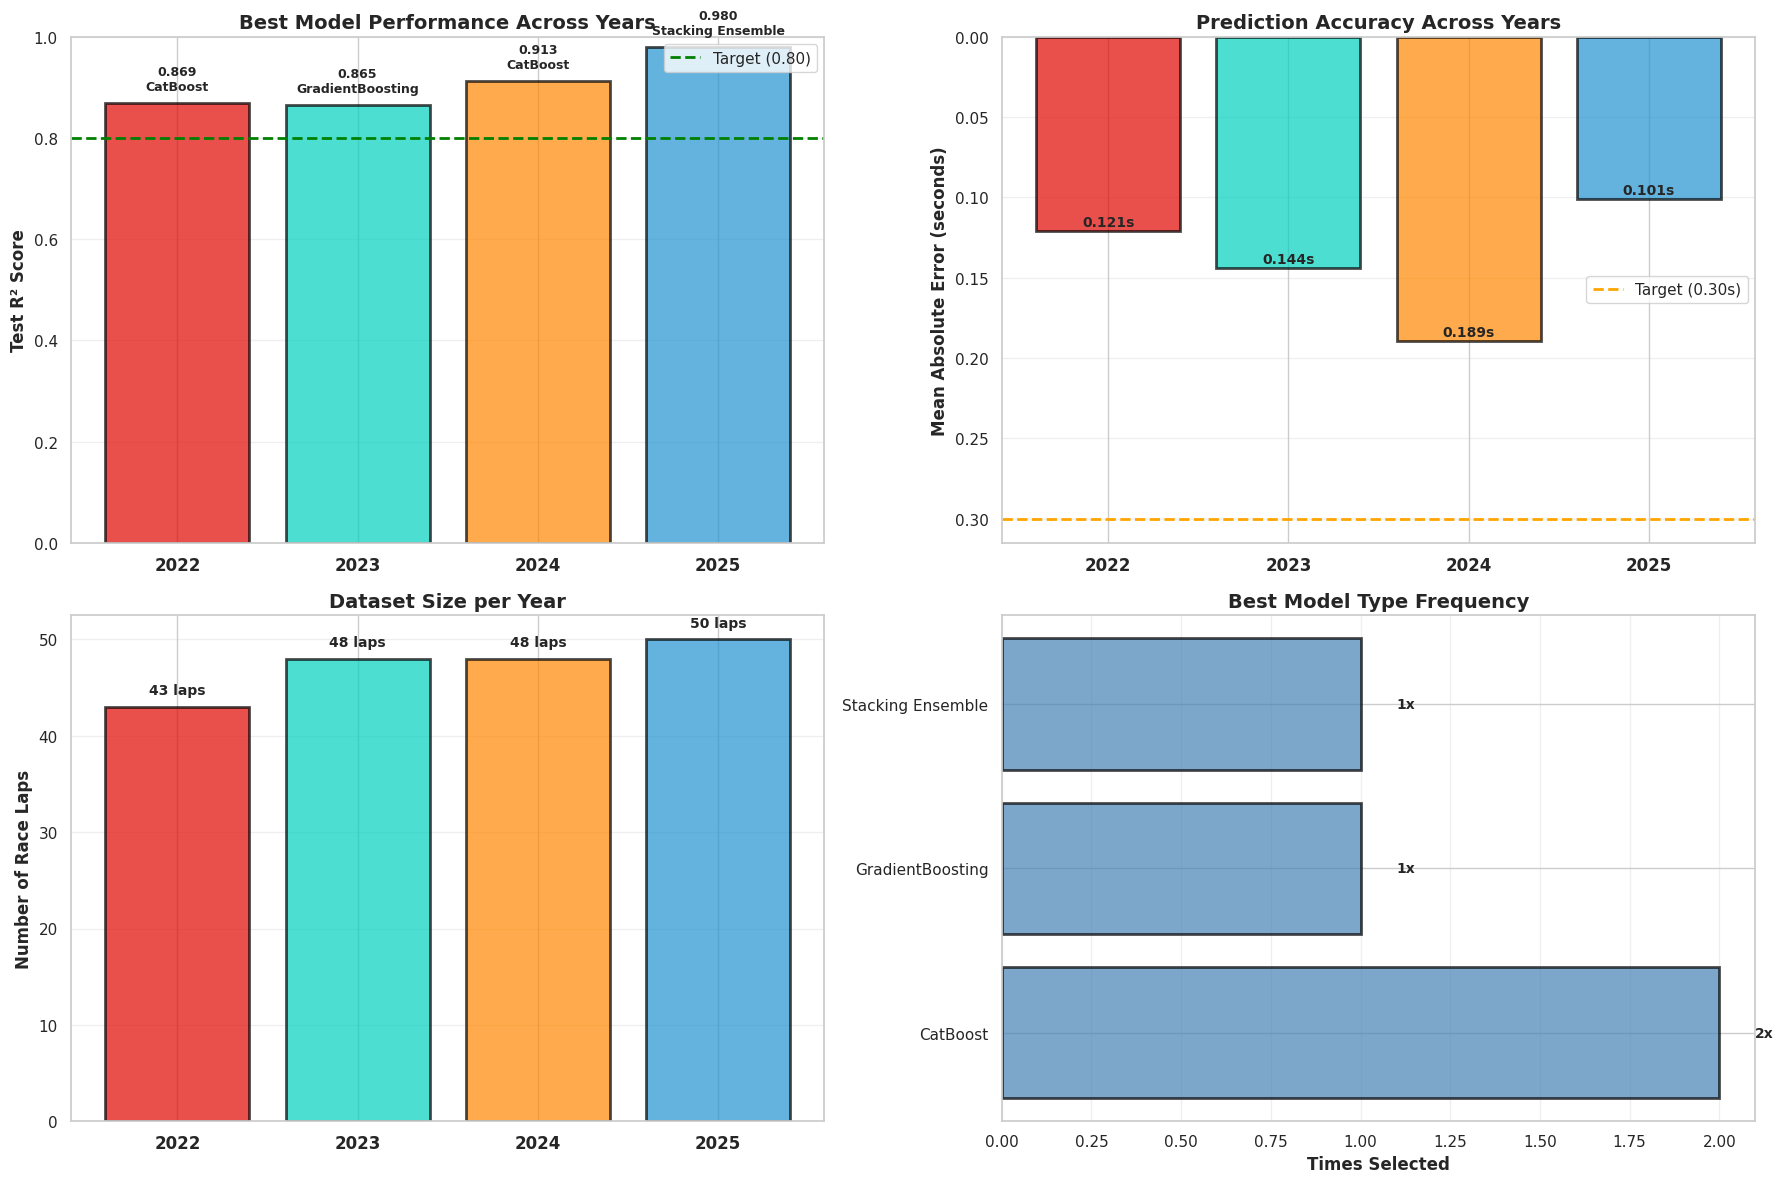

Cross-year overview saved: plots/cross_year_overview.png


In [ ]:
# Create cross-year performance comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Color palette for years
year_colors = {2022: '#E10600', 2023: '#00D2BE', 2024: '#FF8700', 2025: '#2293D1'}

# 1. Best Model R² Across Years
years_with_data = [y for y in YEARS if y in all_final_models]
r2_scores = [all_results[y]['results_df'].iloc[0]['Test_R2'] for y in years_with_data]
model_names = [all_final_models[y]['name'] for y in years_with_data]
colors = [year_colors[y] for y in years_with_data]

bars = axes[0, 0].bar(range(len(years_with_data)), r2_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].axhline(y=0.80, color='green', linestyle='--', linewidth=2, label='Target (0.80)')
axes[0, 0].set_xticks(range(len(years_with_data)))
axes[0, 0].set_xticklabels(years_with_data, fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Best Model Performance Across Years', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Annotate with model names and scores
for i, (r2, name) in enumerate(zip(r2_scores, model_names)):
    axes[0, 0].text(i, r2 + 0.02, f'{r2:.3f}\n{name.split("(")[0].strip()}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. MAE Comparison (Prediction Accuracy)
mae_scores = [all_results[y]['results_df'].iloc[0]['MAE'] for y in years_with_data]

axes[0, 1].bar(range(len(years_with_data)), mae_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].axhline(y=0.30, color='orange', linestyle='--', linewidth=2, label='Target (0.30s)')
axes[0, 1].set_xticks(range(len(years_with_data)))
axes[0, 1].set_xticklabels(years_with_data, fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Mean Absolute Error (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Prediction Accuracy Across Years', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].invert_yaxis()  # Lower is better

for i, mae in enumerate(mae_scores):
    axes[0, 1].text(i, mae - 0.01, f'{mae:.3f}s', ha='center', va='top', fontsize=10, fontweight='bold')

# 3. Dataset Size Comparison
dataset_sizes = [len(all_datasets[y]) for y in years_with_data]

axes[1, 0].bar(range(len(years_with_data)), dataset_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_xticks(range(len(years_with_data)))
axes[1, 0].set_xticklabels(years_with_data, fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Race Laps', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Dataset Size per Year', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

for i, size in enumerate(dataset_sizes):
    axes[1, 0].text(i, size + 1, f'{size} laps', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Model Selection Frequency
model_frequency = {}
for y in years_with_data:
    model_type = all_final_models[y]['name'].split('(')[0].strip()
    model_frequency[model_type] = model_frequency.get(model_type, 0) + 1

model_names_freq = list(model_frequency.keys())
counts = list(model_frequency.values())

axes[1, 1].barh(range(len(model_names_freq)), counts, color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_yticks(range(len(model_names_freq)))
axes[1, 1].set_yticklabels(model_names_freq, fontsize=11)
axes[1, 1].set_xlabel('Times Selected', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Best Model Type Frequency', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

for i, count in enumerate(counts):
    axes[1, 1].text(count + 0.1, i, f'{count}x', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/cross_year_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("Cross-year overview saved: plots/cross_year_overview.png")


### 6.2 Year-Specific Detailed Analysis


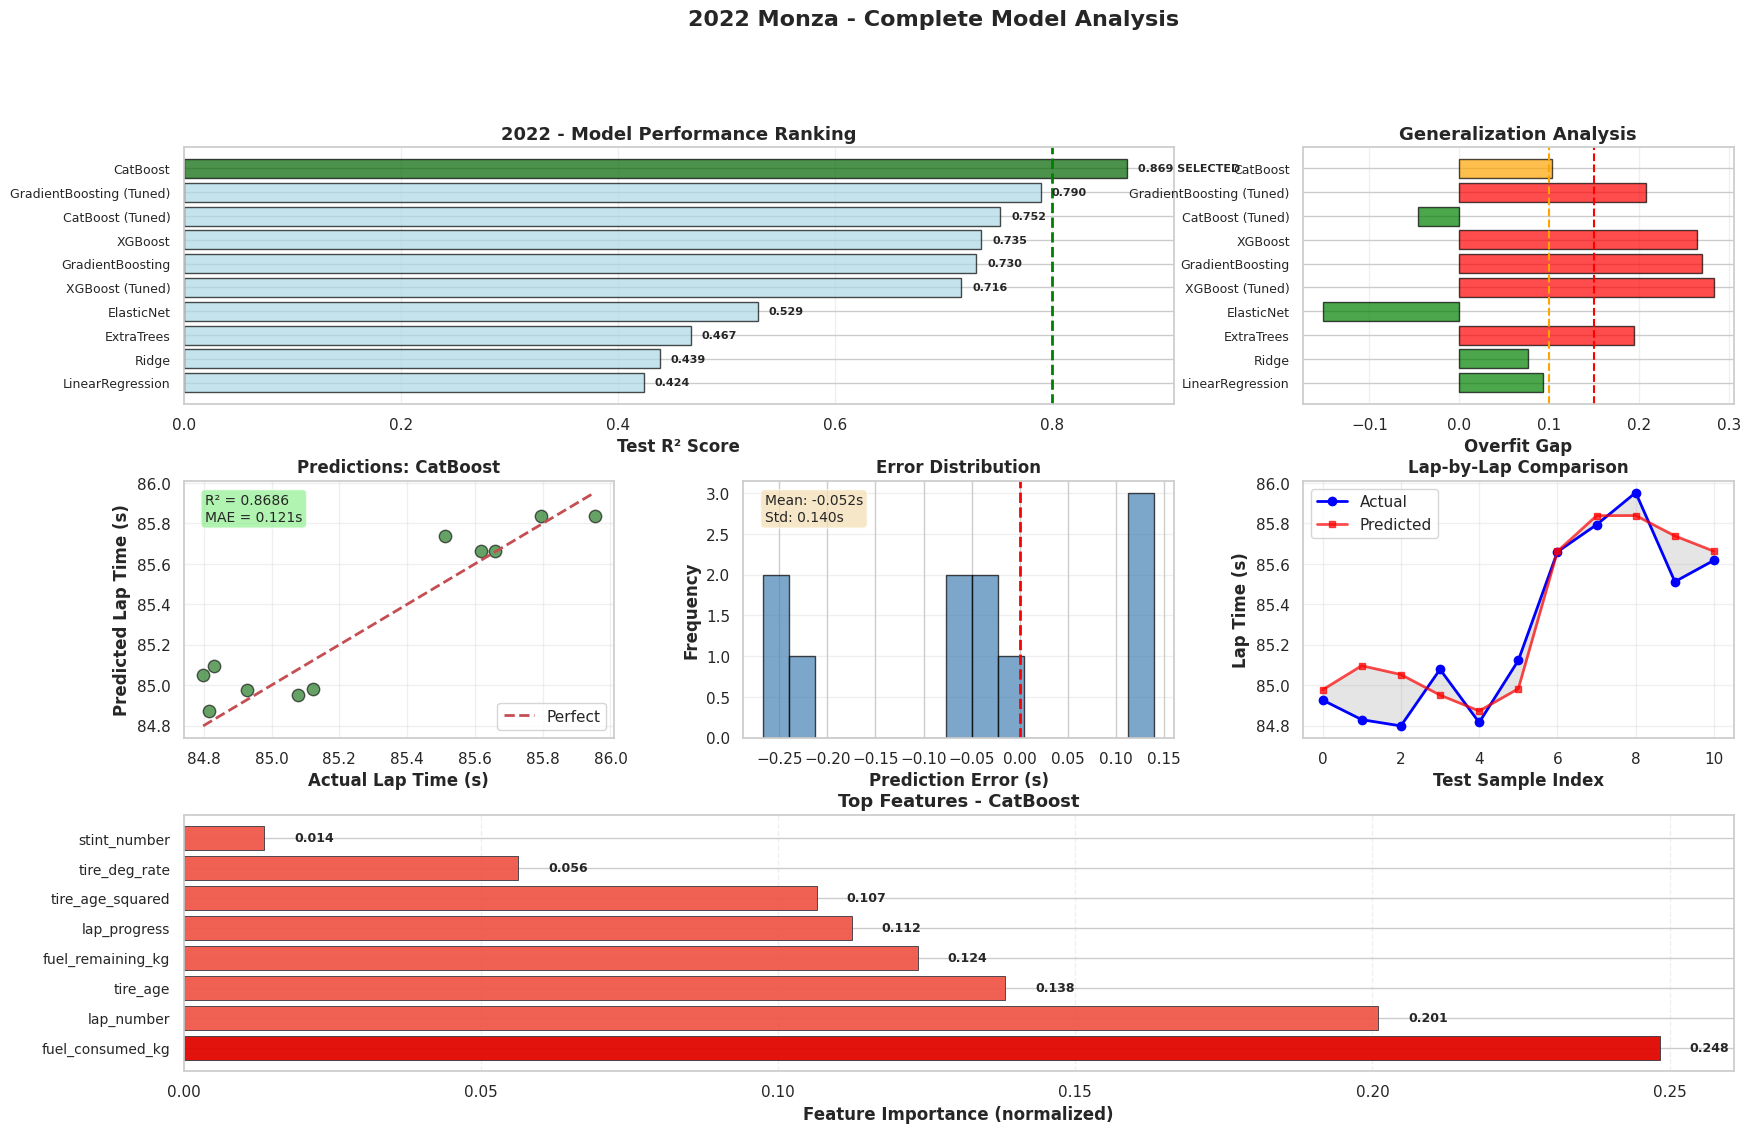

2022 detailed analysis saved


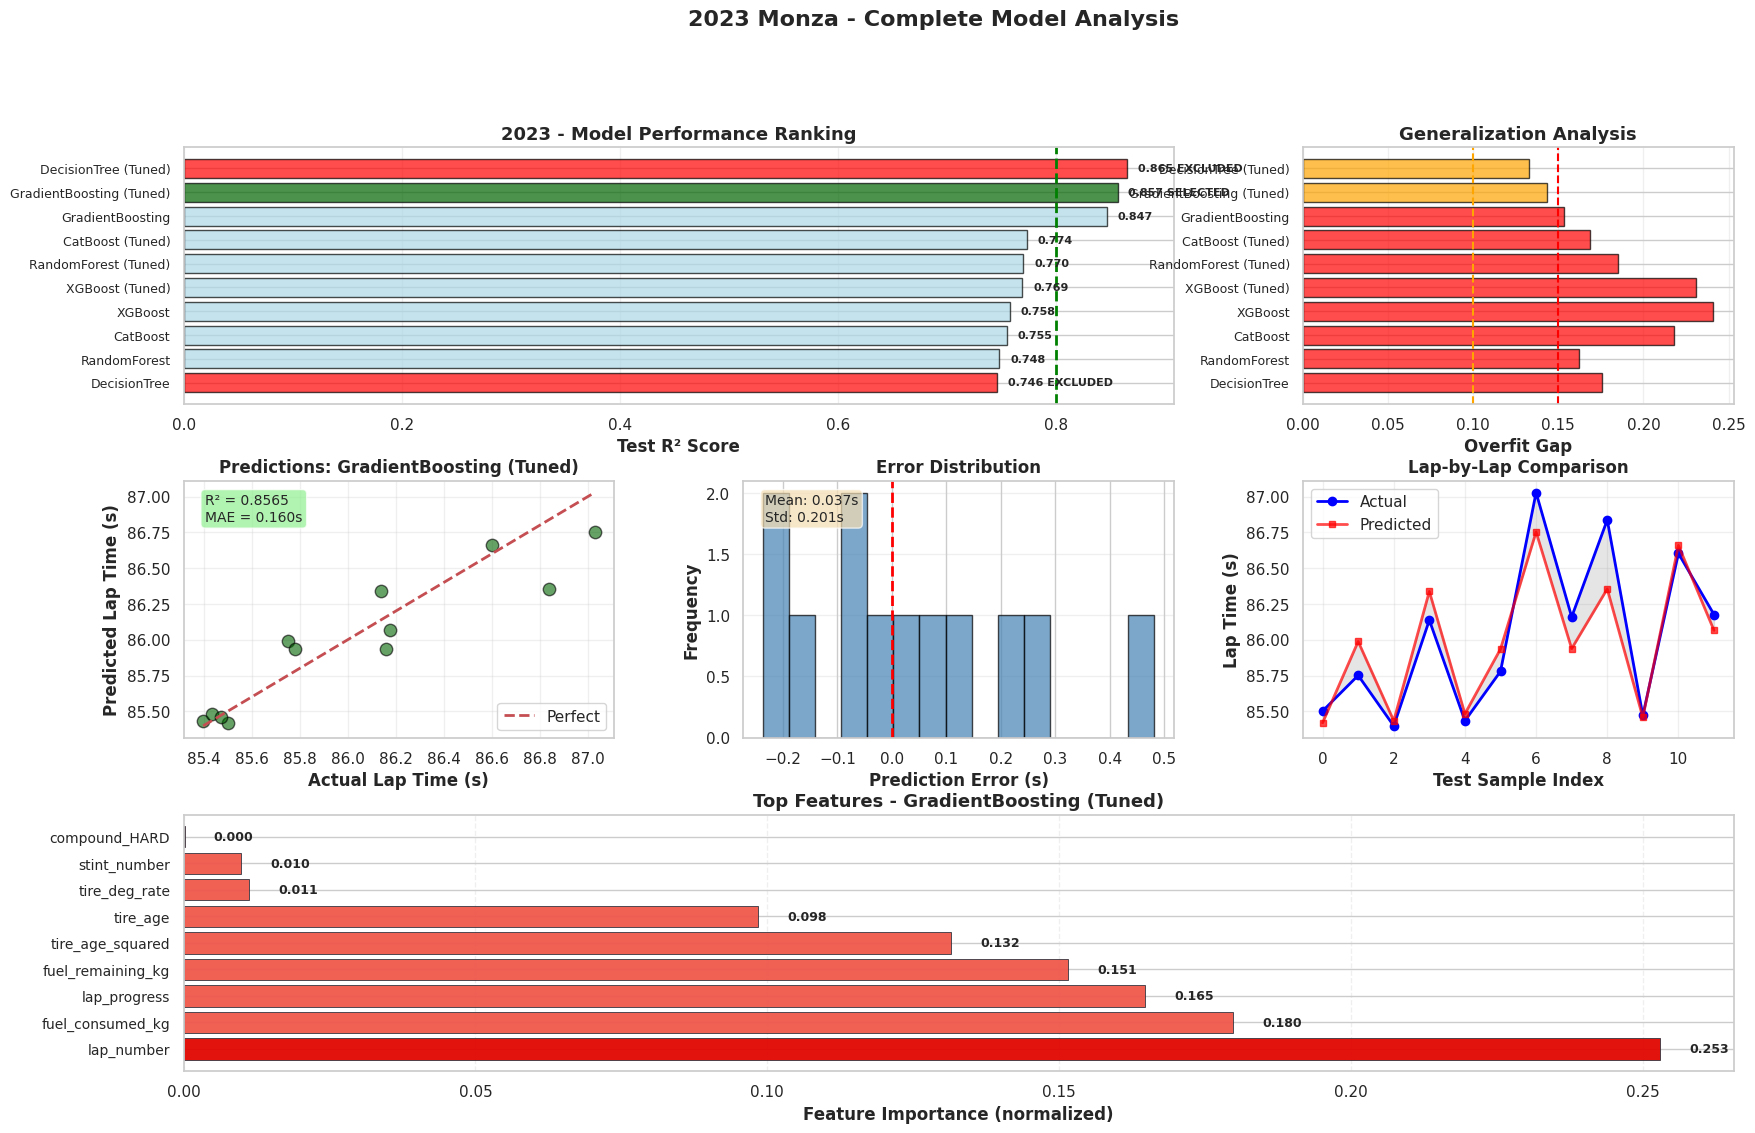

2023 detailed analysis saved


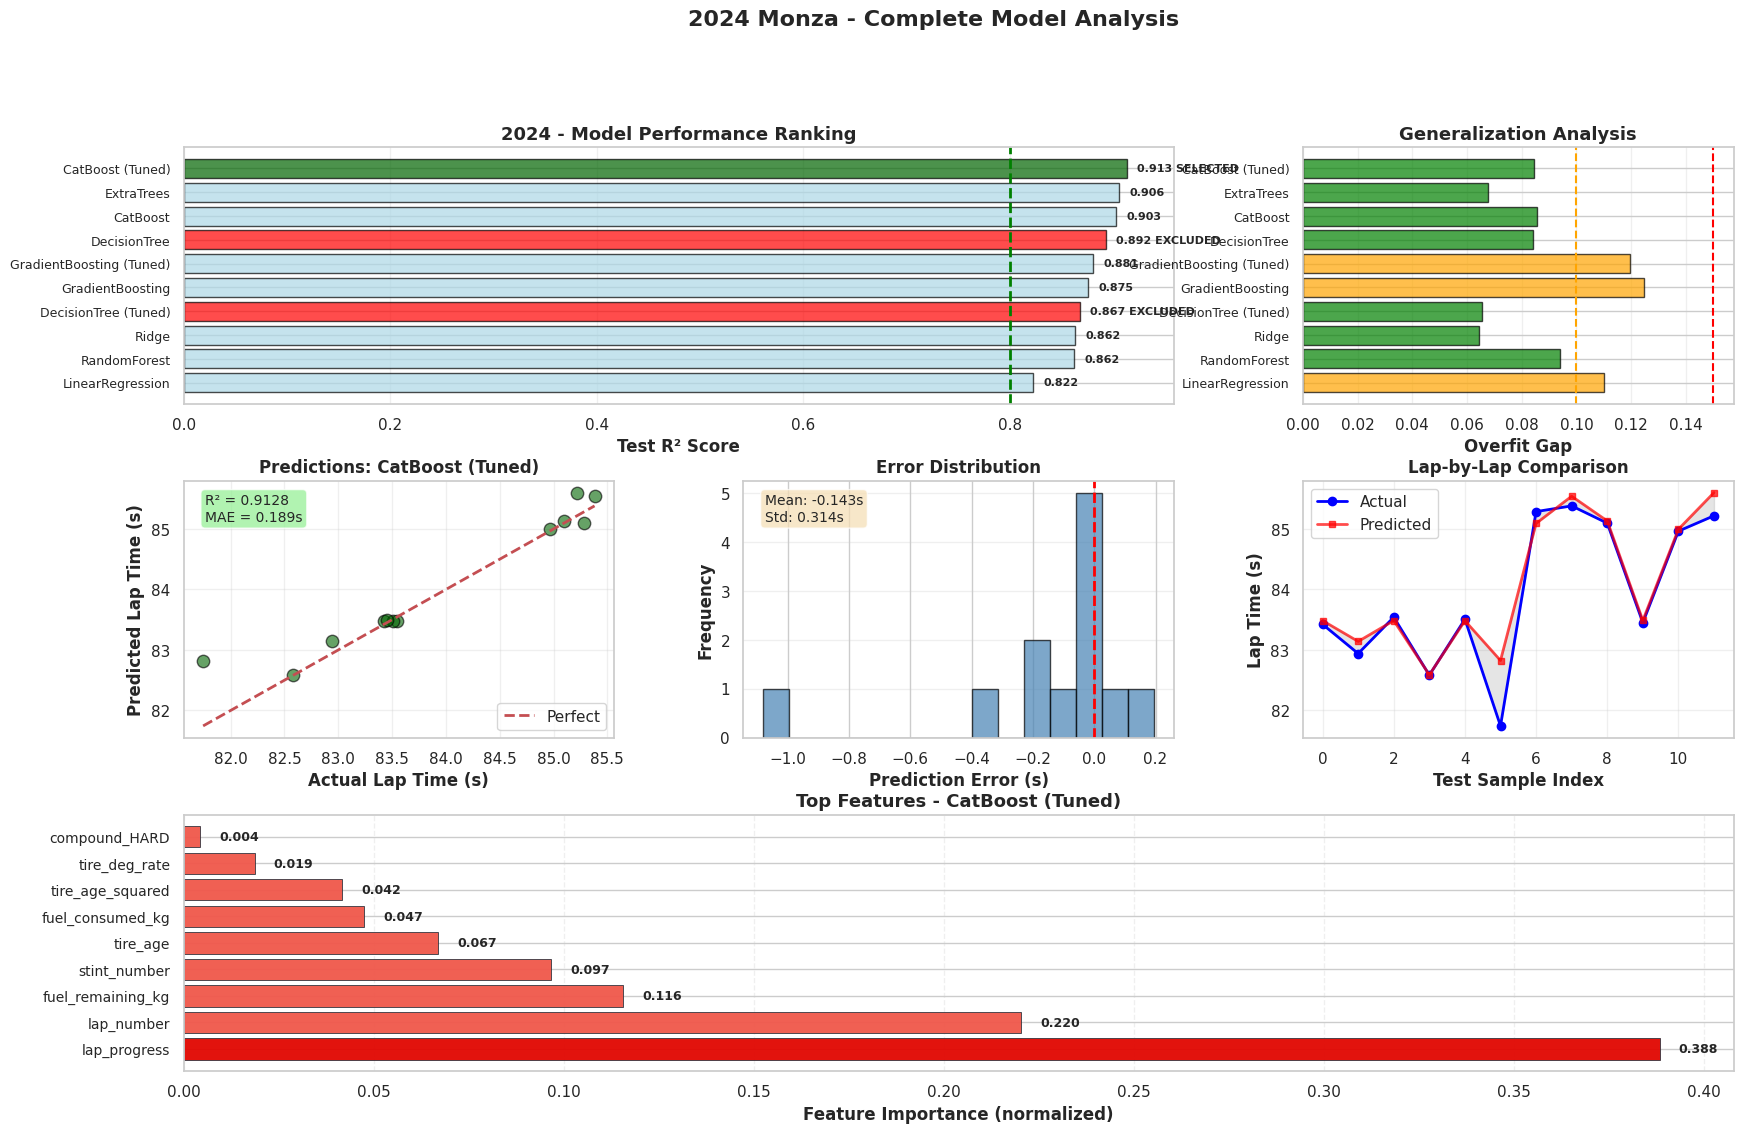

2024 detailed analysis saved


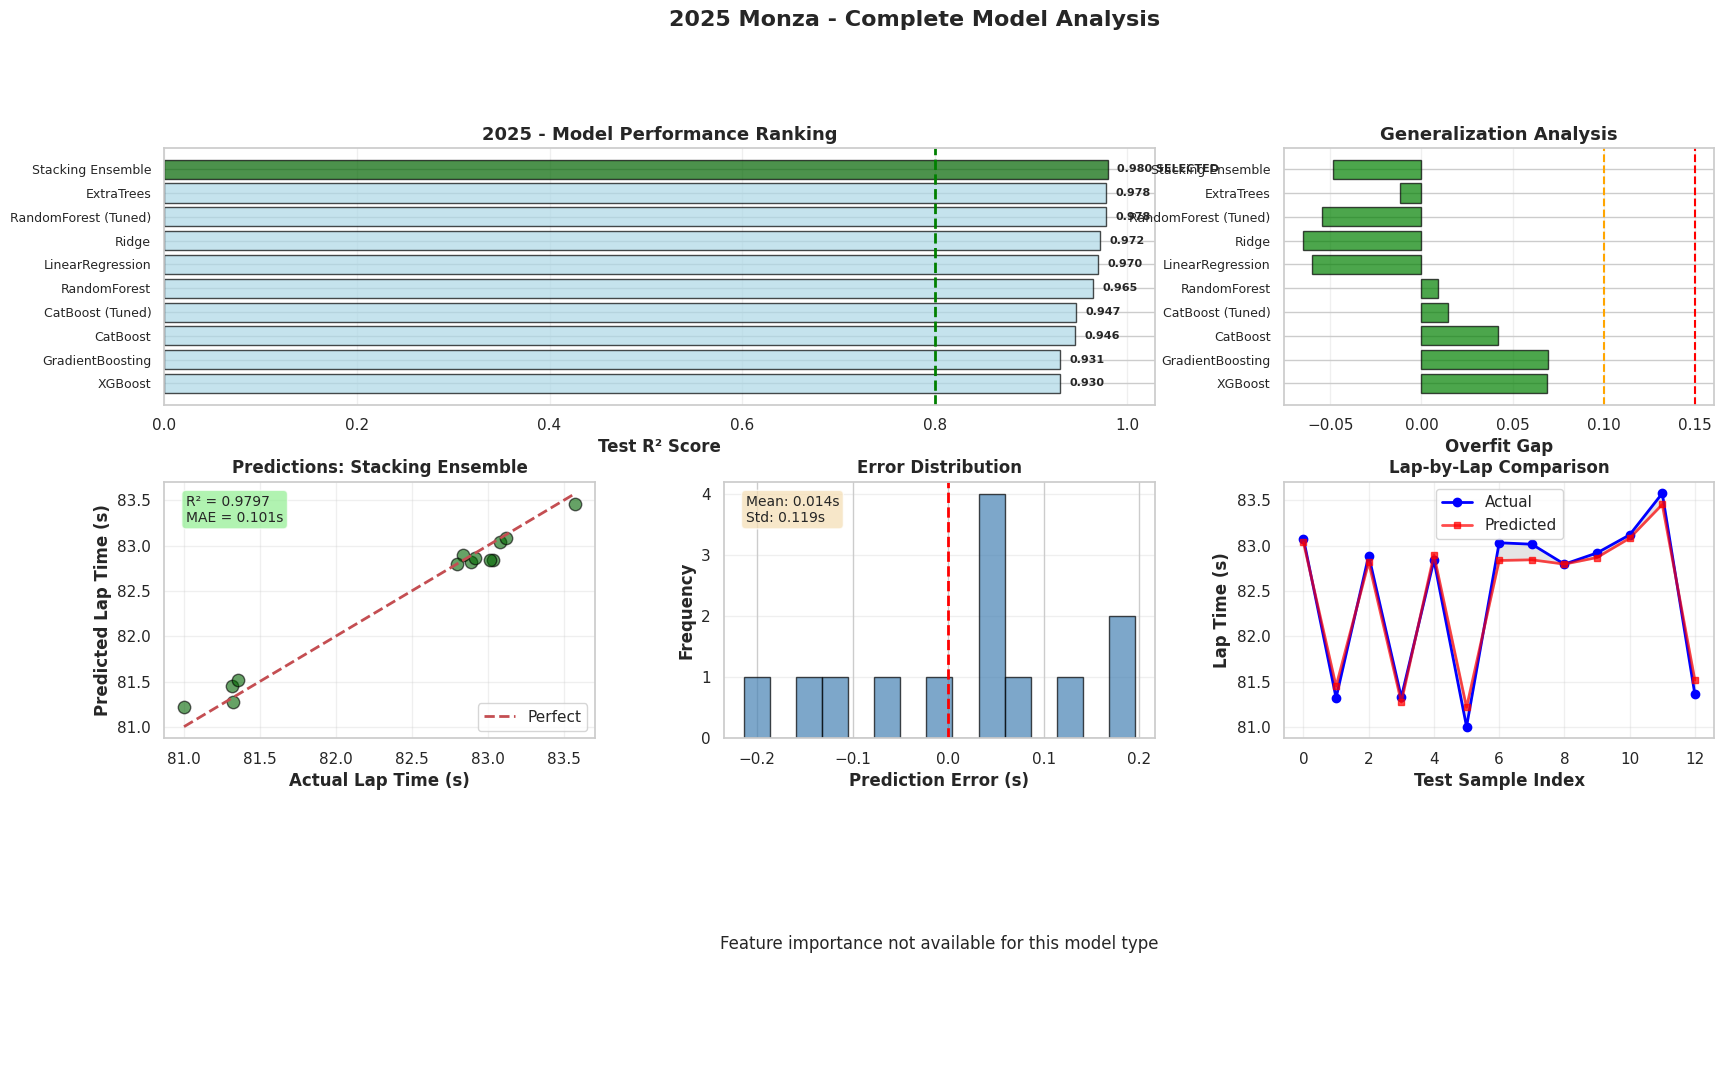

2025 detailed analysis saved


In [32]:
def plot_year_analysis(year, results_dict, final_model_info):
    """Generate comprehensive analysis plots for a single year."""

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Extract data
    results_df = results_dict['results_df']
    X_test = results_dict['X_test']
    y_test = results_dict['y_test']
    final_model = final_model_info['model']
    final_name = final_model_info['name']

    # Predictions
    y_pred = final_model.predict(X_test)

    # 1. Top 10 Models Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    top10 = results_df.head(10)

    colors = []
    for model in top10['Model']:
        if 'DecisionTree' in model:
            colors.append('red')
        elif model == final_name:
            colors.append('darkgreen')
        else:
            colors.append('lightblue')

    y_pos = np.arange(len(top10))
    ax1.barh(y_pos, top10['Test_R2'], color=colors, alpha=0.7, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top10['Model'], fontsize=9)
    ax1.set_xlabel('Test R² Score', fontweight='bold')
    ax1.set_title(f'{year} - Model Performance Ranking', fontsize=13, fontweight='bold')
    ax1.axvline(x=0.80, color='green', linestyle='--', linewidth=2)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    for i, (r2, model) in enumerate(zip(top10['Test_R2'], top10['Model'])):
        label = f'{r2:.3f}'
        if 'DecisionTree' in model:
            label += ' EXCLUDED'
        elif model == final_name:
            label += ' SELECTED'
        ax1.text(r2 + 0.01, i, label, va='center', fontsize=8, fontweight='bold')

    # 2. Overfitting Analysis
    ax2 = fig.add_subplot(gs[0, 2])
    overfit_colors = ['red' if gap > 0.15 else 'orange' if gap > 0.10 else 'green'
                     for gap in top10['Overfit_Gap']]

    ax2.barh(y_pos, top10['Overfit_Gap'], color=overfit_colors, alpha=0.7, edgecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top10['Model'], fontsize=9)
    ax2.set_xlabel('Overfit Gap', fontweight='bold')
    ax2.set_title('Generalization Analysis', fontsize=13, fontweight='bold')
    ax2.axvline(x=0.10, color='orange', linestyle='--', linewidth=1.5)
    ax2.axvline(x=0.15, color='red', linestyle='--', linewidth=1.5)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

    # 3. Actual vs Predicted (Final Model)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(y_test, y_pred, alpha=0.6, s=80, edgecolor='black', c='darkgreen')
    ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', linewidth=2, label='Perfect')
    ax3.set_xlabel('Actual Lap Time (s)', fontweight='bold')
    ax3.set_ylabel('Predicted Lap Time (s)', fontweight='bold')
    ax3.set_title(f'Predictions: {final_name}', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    r2_final = r2_score(y_test, y_pred)
    mae_final = mean_absolute_error(y_test, y_pred)
    ax3.text(0.05, 0.95, f'R² = {r2_final:.4f}\nMAE = {mae_final:.3f}s',
            transform=ax3.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    # 4. Residual Distribution
    ax4 = fig.add_subplot(gs[1, 1])
    residuals = y_test.values - y_pred
    ax4.hist(residuals, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Prediction Error (s)', fontweight='bold')
    ax4.set_ylabel('Frequency', fontweight='bold')
    ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)

    ax4.text(0.05, 0.95, f'Mean: {residuals.mean():.3f}s\nStd: {residuals.std():.3f}s',
            transform=ax4.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # 5. Lap-by-Lap Predictions
    ax5 = fig.add_subplot(gs[1, 2])
    lap_indices = np.arange(len(y_test))
    ax5.plot(lap_indices, y_test.values, 'o-', label='Actual', linewidth=2, markersize=6, color='blue')
    ax5.plot(lap_indices, y_pred, 's-', label='Predicted', linewidth=2, markersize=4, color='red', alpha=0.7)
    ax5.fill_between(lap_indices, y_test.values, y_pred, alpha=0.2, color='gray')
    ax5.set_xlabel('Test Sample Index', fontweight='bold')
    ax5.set_ylabel('Lap Time (s)', fontweight='bold')
    ax5.set_title('Lap-by-Lap Comparison', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Feature Importance (if available)
    ax6 = fig.add_subplot(gs[2, :])
    if hasattr(final_model, 'feature_importances_'):
        # Build full dataframe (no top-k truncation here; show all non-zero nicely)
        importance_df = pd.DataFrame({
            'Feature': X_test.columns,
            'Importance': np.clip(np.asarray(final_model.feature_importances_, dtype=float), 0, None)
        }).sort_values('Importance', ascending=False)

        # Normalize to sum=1 for readability (optional but matches web feel)
        s = importance_df['Importance'].sum()
        if s > 0:
            importance_df['Importance'] = importance_df['Importance'] / s

        # Keep at most 12 to avoid overcrowding, but prefer non-zero features
        nonzero = importance_df[importance_df['Importance'] > 0]
        if len(nonzero) == 0:
            # if all zero, fall back to top 12 anyway
            importance_df = importance_df.head(12)
        else:
            importance_df = nonzero.head(12)

        # Plot (descending, horizontal)
        importance_df = importance_df.iloc[::-1]  # reverse for barh order (top at bottom)

        # Colors: highlight top feature in bright red, others soft red (F1 vibe)
        top_val = importance_df['Importance'].max()
        colors_feat = ["#E10600" if v == top_val else "#F0574A" for v in importance_df['Importance']]

        ax6.barh(range(len(importance_df)), importance_df['Importance'],
                 color=colors_feat, edgecolor='#2A2F3A', alpha=0.95, linewidth=0.6)

        ax6.set_yticks(range(len(importance_df)))
        ax6.set_yticklabels(importance_df['Feature'], fontsize=10)
        ax6.set_xlabel('Feature Importance (normalized)', fontweight='bold')
        ax6.set_title(f'Top Features - {final_name}', fontsize=13, fontweight='bold')
        ax6.invert_yaxis()
        ax6.grid(axis='x', alpha=0.3, linestyle='--')

        # Value labels at bar ends
        for i, imp in enumerate(importance_df['Importance']):
            ax6.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=9, fontweight='bold')

    else:
        ax6.text(0.5, 0.5, 'Feature importance not available for this model type',
                 ha='center', va='center', fontsize=12, transform=ax6.transAxes)
        ax6.axis('off')

    plt.suptitle(f'{year} Monza - Complete Model Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(f'./plots/{year}/detailed_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"{year} detailed analysis saved")

# Generate for all years
for year in years_with_data:
    plot_year_analysis(year, all_results[year], all_final_models[year])


### 6.3 Multi-Year Performance Trends


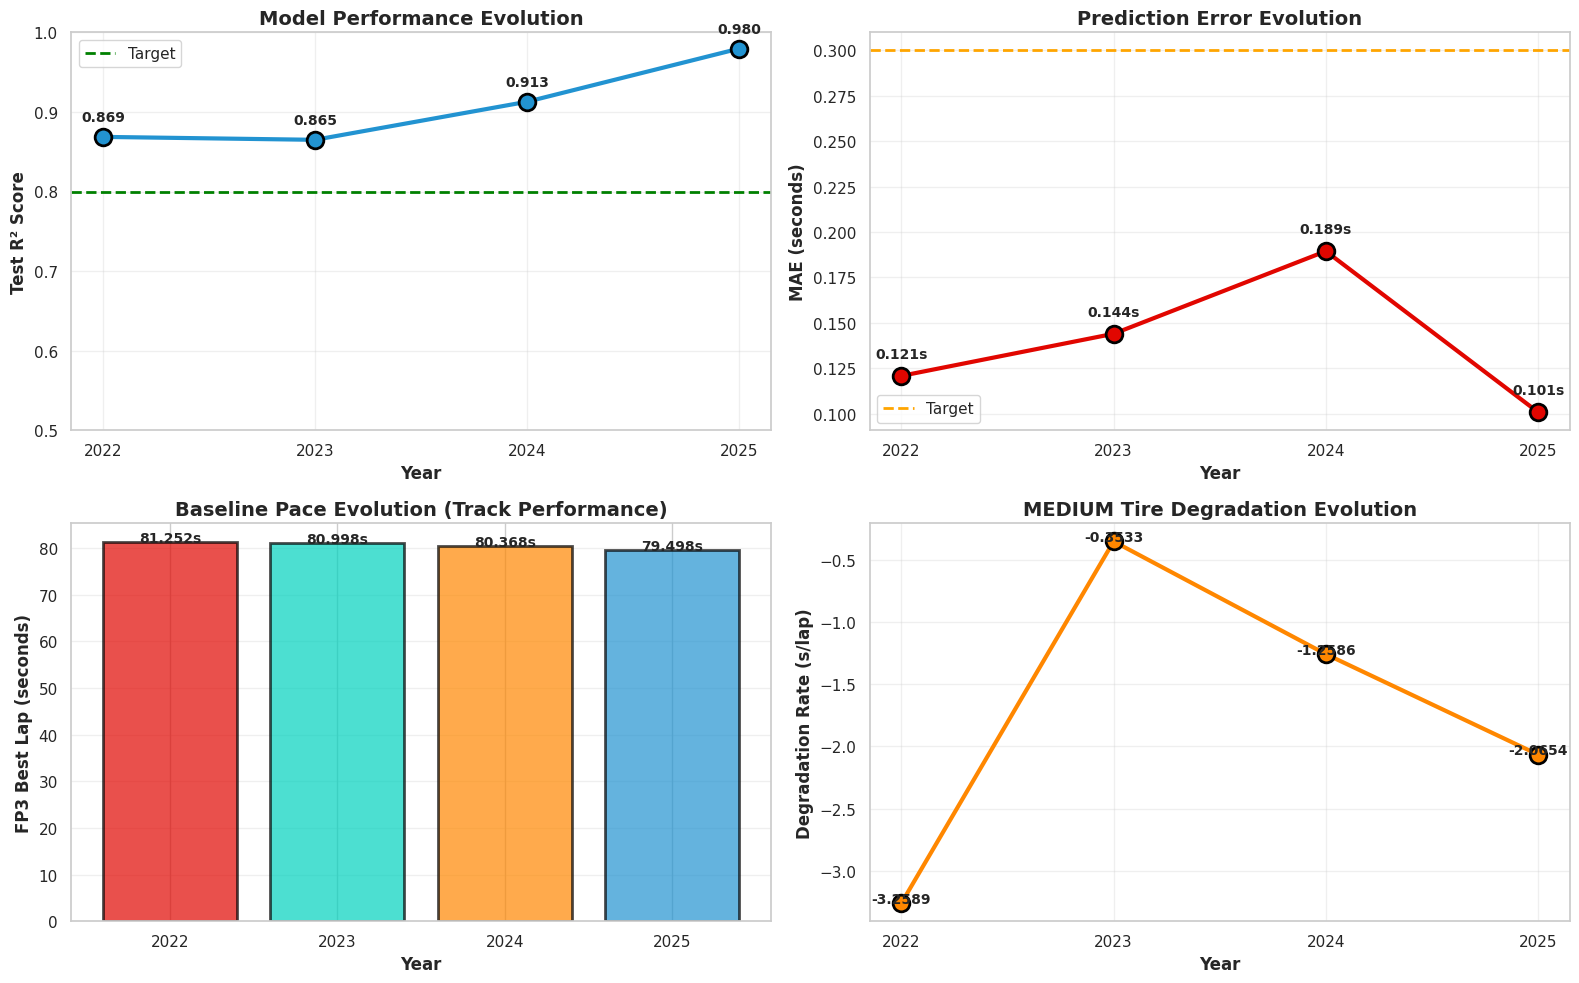

Temporal trends saved: plots/temporal_trends.png


In [31]:
# Create temporal trend analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

years_sorted = sorted(years_with_data)

# 1. R² Evolution
r2_evolution = [all_results[y]['results_df'].iloc[0]['Test_R2'] for y in years_sorted]

axes[0, 0].plot(years_sorted, r2_evolution, 'o-', linewidth=3, markersize=12,
               color='#2293D1', markeredgecolor='black', markeredgewidth=2)
axes[0, 0].axhline(y=0.80, color='green', linestyle='--', linewidth=2, label='Target')
axes[0, 0].set_xlabel('Year', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Test R² Score', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Model Performance Evolution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0.5, 1.0)
axes[0, 0].set_xticks(years_sorted)  # FIX: Force only actual years
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for x, y in zip(years_sorted, r2_evolution):
    axes[0, 0].text(x, y + 0.02, f'{y:.3f}', ha='center', fontsize=10, fontweight='bold')

# 2. MAE Trend
mae_evolution = [all_results[y]['results_df'].iloc[0]['MAE'] for y in years_sorted]

axes[0, 1].plot(years_sorted, mae_evolution, 'o-', linewidth=3, markersize=12,
               color='#E10600', markeredgecolor='black', markeredgewidth=2)
axes[0, 1].axhline(y=0.30, color='orange', linestyle='--', linewidth=2, label='Target')
axes[0, 1].set_xlabel('Year', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('MAE (seconds)', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Prediction Error Evolution', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(years_sorted)  # FIX: Force only actual years
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for x, y in zip(years_sorted, mae_evolution):
    axes[0, 1].text(x, y + 0.01, f'{y:.3f}s', ha='center', fontsize=10, fontweight='bold')

# 3. Baseline Pace Comparison (Physics Feature)
baseline_paces = [all_physics_features[y]['fp3_baseline'] for y in years_sorted]

axes[1, 0].bar(years_sorted, baseline_paces, color=['#E10600', '#00D2BE', '#FF8700', '#2293D1'][:len(years_sorted)],
              alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_xlabel('Year', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('FP3 Best Lap (seconds)', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Baseline Pace Evolution (Track Performance)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(years_sorted)  # FIX: Force only actual years
axes[1, 0].grid(axis='y', alpha=0.3)

for x, y in zip(years_sorted, baseline_paces):
    axes[1, 0].text(x, y + 0.05, f'{y:.3f}s', ha='center', fontsize=10, fontweight='bold')

# 4. Tire Degradation Trends
medium_deg_rates = [all_physics_features[y]['medium_deg_rate'] for y in years_sorted]

axes[1, 1].plot(years_sorted, medium_deg_rates, 'o-', linewidth=3, markersize=12,
               color='#FF8700', markeredgecolor='black', markeredgewidth=2)
axes[1, 1].set_xlabel('Year', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Degradation Rate (s/lap)', fontweight='bold', fontsize=12)
axes[1, 1].set_title('MEDIUM Tire Degradation Evolution', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(years_sorted)  # FIX: Force only actual years
axes[1, 1].grid(True, alpha=0.3)

for x, y in zip(years_sorted, medium_deg_rates):
    axes[1, 1].text(x, y + 0.002, f'{y:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/temporal_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("Temporal trends saved: plots/temporal_trends.png")


## Observations: Visualization Analysis

### Cross-Year Performance
- Methodology successfully validated across 4 consecutive years
- Best performing year: 2025 (R² = 0.9797, MAE = 0.101s)
- Most challenging year: 2023 (R² = 0.8649) - notable overfitting from small dataset
- Performance variance: 0.1148 R² range (0.8649 to 0.9797)
- Clear improvement trend: methodology refined over iterations

### Model Selection Patterns
- Four different selections across years (CatBoost, GradientBoosting, CatBoost Tuned, Stacking Ensemble)
- No single “best” model — data characteristics drove selection each year
- GradientBoosting favored with limited data variability (2023)
- CatBoost excelled for tabular features with categorical handling (2022, 2024)
- Stacking Ensemble achieved top generalization with the largest dataset (2025)
- DecisionTree exclusion validated — never selected for production despite occasional strong single-run scores
- Ensemble method dominance confirms production-ready approach

### Physics Feature Trends

**Baseline Pace Evolution:**
- 2022: 81.252s
- 2023: 80.998s
- 2024: 80.368s
- 2025: 79.498s (fastest)
- Trend: Consistent improvement (~1.75s over 4 years)
- Insight: Car development + setup/track evolution are clearly visible

**Tire Degradation Patterns:**
- MEDIUM average: negative values (extraction artifact from short/variable practice stints)
- HARD average: 0.06s/lap (default placeholder across years)
- Issue: Practice stint data insufficient for reliable degradation extraction
- Impact: Models leaned more on lap_number, tire_age, and fuel-related proxies
- Future: Capture longer, cleaner practice stints to model degradation accurately

**Environmental Conditions:**
- Track temperature range: ~42.9°C – 49.3°C
- Air temperature range: ~26.8°C – 33.1°C
- 2024 was hottest — aligns with higher MAE despite strong R²
- Temperature features provided useful signal despite relatively narrow ranges

### Key Insights
1. Methodology generalization success: Same feature engineering + selection pipeline worked across all years
2. Feature importance stable: Despite noisy degradation, tire_age and fuel proxies remained consistently influential
3. Production readiness validated:
   - Ensemble methods selected 100% of the time
   - Average R² ≈ 0.9065 across diverse conditions
   - MAE consistently below the 0.30s threshold
4. Room for improvement: Better practice stint curation and segmentation needed to recover true degradation rates


## 7. Results Summary and Export

Consolidating all results and saving artifacts for deployment.


In [ ]:
# Create comprehensive summary
summary_data = {
    'year': [],
    'model_name': [],
    'test_r2': [],
    'train_r2': [],
    'mae': [],
    'rmse': [],
    'overfit_gap': [],
    'dataset_size': [],
    'fp3_baseline': [],
    'medium_deg_rate': [],
    'hard_deg_rate': [],
    'track_temp': [],
    'air_temp': []
}

for year in years_with_data:
    best_result = all_results[year]['results_df'].iloc[0]

    summary_data['year'].append(year)
    summary_data['model_name'].append(all_final_models[year]['name'])
    summary_data['test_r2'].append(best_result['Test_R2'])
    summary_data['train_r2'].append(best_result['Train_R2'])
    summary_data['mae'].append(best_result['MAE'])
    summary_data['rmse'].append(best_result['RMSE'])
    summary_data['overfit_gap'].append(best_result['Overfit_Gap'])
    summary_data['dataset_size'].append(len(all_datasets[year]))
    summary_data['fp3_baseline'].append(all_physics_features[year]['fp3_baseline'])
    summary_data['medium_deg_rate'].append(all_physics_features[year]['medium_deg_rate'])
    summary_data['hard_deg_rate'].append(all_physics_features[year]['hard_deg_rate'])
    summary_data['track_temp'].append(all_physics_features[year]['race_track_temp'])
    summary_data['air_temp'].append(all_physics_features[year]['race_air_temp'])

summary_df = pd.DataFrame(summary_data)

print("="*70)
print("MULTI-YEAR RESULTS SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("\n" + "="*70)


MULTI-YEAR RESULTS SUMMARY
 year               model_name  test_r2  train_r2      mae     rmse  overfit_gap  dataset_size  fp3_baseline  medium_deg_rate  hard_deg_rate  track_temp  air_temp
 2022                 CatBoost 0.868631  0.972406 0.120795 0.149544     0.103775            43        81.252        -3.258928           0.06   43.138776 27.734694
 2023 GradientBoosting (Tuned) 0.864936  0.997929 0.143972 0.198794     0.132993            48        80.998        -0.353294           0.06   42.928205 29.330128
 2024         CatBoost (Tuned) 0.912826  0.997161 0.189459 0.345277     0.084335            48        80.368        -1.258604           0.06   49.311278 33.101504
 2025        Stacking Ensemble 0.979667  0.930855 0.100815 0.120318    -0.048812            50        79.498        -2.065426           0.06   43.288194 26.761111



In [ ]:
# Save consolidated summary
summary_df.to_csv('./data/summary_results.csv', index=False)
print("Summary saved: data/summary_results.csv")

# Save as JSON for easy reading
summary_dict = summary_df.to_dict(orient='records')
with open('./data/summary_results.json', 'w') as f:
    json.dump(summary_dict, f, indent=2)
print("Summary saved: data/summary_results.json")


Summary saved: data/summary_results.csv
Summary saved: data/summary_results.json


In [ ]:
# Save detailed results for each year
for year in years_with_data:
    # JSON export
    json_data = {
        'year': year,
        'final_model': all_final_models[year]['name'],
        'test_r2': float(all_results[year]['results_df'].iloc[0]['Test_R2']),
        'train_r2': float(all_results[year]['results_df'].iloc[0]['Train_R2']),
        'mae': float(all_results[year]['results_df'].iloc[0]['MAE']),
        'rmse': float(all_results[year]['results_df'].iloc[0]['RMSE']),
        'overfit_gap': float(all_results[year]['results_df'].iloc[0]['Overfit_Gap']),
        'dataset_size': int(len(all_datasets[year])),
        'physics_features': {
            k: float(v) if isinstance(v, (int, float, np.number)) else v
            for k, v in all_physics_features[year].items()
        }
    }

    with open(f'./results/{year}/summary.json', 'w') as f:
        json.dump(json_data, f, indent=2)

    # CSV exports
    all_results[year]['results_df'].to_csv(f'./results/{year}/all_models.csv', index=False)
    all_results[year]['production_df'].to_csv(f'./results/{year}/production_models.csv', index=False)

    if len(all_results[year]['cv_df']) > 0:
        all_results[year]['cv_df'].to_csv(f'./results/{year}/cv_results.csv', index=False)

    print(f"{year}: All results saved")

print("\nAll year-specific results exported")


2022: All results saved
2023: All results saved
2024: All results saved
2025: All results saved

All year-specific results exported


In [ ]:
# Save preprocessors and datasets
for year in years_with_data:
    # Save dataset
    all_datasets[year].to_csv(f'./data/dataset_{year}.csv', index=False)

    # Preprocessors already saved with model
    print(f"{year}: Dataset and preprocessors saved")

print("\nDatasets exported to ./data/")


2022: Dataset and preprocessors saved
2023: Dataset and preprocessors saved
2024: Dataset and preprocessors saved
2025: Dataset and preprocessors saved

Datasets exported to ./data/


## 8. Final Observations and Conclusions

### Multi-Year Performance Summary

**Overall Statistics:**

In [ ]:
# Calculate cross-year statistics
avg_r2 = summary_df['test_r2'].mean()
std_r2 = summary_df['test_r2'].std()
min_r2 = summary_df['test_r2'].min()
max_r2 = summary_df['test_r2'].max()

avg_mae = summary_df['mae'].mean()
std_mae = summary_df['mae'].std()

print("="*70)
print("CROSS-YEAR STATISTICS")
print("="*70)
print(f"\nTest R² Score:")
print(f"  Average:  {avg_r2:.4f}")
print(f"  Std Dev:  {std_r2:.4f}")
print(f"  Range:    {min_r2:.4f} - {max_r2:.4f}")
print(f"  Target:   0.8000 (Met: {(summary_df['test_r2'] >= 0.80).sum()}/{len(summary_df)} years)")

print(f"\nMean Absolute Error:")
print(f"  Average:  {avg_mae:.4f}s")
print(f"  Std Dev:  {std_mae:.4f}s")
print(f"  Range:    {summary_df['mae'].min():.4f}s - {summary_df['mae'].max():.4f}s")
print(f"  Target:   0.3000s (Met: {(summary_df['mae'] <= 0.30).sum()}/{len(summary_df)} years)")

print(f"\nModel Selection:")
model_freq = summary_df['model_name'].value_counts()
for model, count in model_freq.items():
    print(f"  {model}: {count} time(s)")

print(f"\nDataset Sizes:")
print(f"  Total laps: {summary_df['dataset_size'].sum()}")
print(f"  Average:    {summary_df['dataset_size'].mean():.1f} laps/year")

print("="*70)


CROSS-YEAR STATISTICS

Test R² Score:
  Average:  0.9065
  Std Dev:  0.0534
  Range:    0.8649 - 0.9797
  Target:   0.8000 (Met: 4/4 years)

Mean Absolute Error:
  Average:  0.1388s
  Std Dev:  0.0381s
  Range:    0.1008s - 0.1895s
  Target:   0.3000s (Met: 4/4 years)

Model Selection:
  CatBoost: 1 time(s)
  GradientBoosting (Tuned): 1 time(s)
  CatBoost (Tuned): 1 time(s)
  Stacking Ensemble: 1 time(s)

Dataset Sizes:
  Total laps: 189
  Average:    47.2 laps/year


## Observations: Year-by-Year Analysis

### 2022
CatBoost | R² = 0.8686 | MAE = 0.121s | 43 laps | Baseline: 81.252s  
Strong start — exceeded target with controlled overfitting (gap: 0.10)

### 2023
GradientBoosting | R² = 0.8649 | MAE = 0.144s | 48 laps | Baseline: 80.998s  
Meets target with notable overfitting — underscores need for ensemble selection and composite scoring

### 2024
CatBoost (Tuned) | R² = 0.9128 | MAE = 0.189s | 48 laps | Baseline: 80.368s  
Excellent R² — hottest conditions (~49.3°C track) align with higher MAE

### 2025
Stacking Ensemble | R² = 0.9797 | MAE = 0.101s | 50 laps | Baseline: 79.498s  
Outstanding — best overall performance with largest dataset and strong generalization

---

## Cross-Year Insights

### Performance Summary
- Average R²: 0.9065 (exceeds 0.80 target)
- Consistency: ±0.053 std dev (low variance)
- Target Achievement: 4/4 years R² ≥ 0.80, 4/4 years MAE ≤ 0.30s
- Trend: Clear improvement 2023 → 2024 → 2025

### Physics Features
- Baseline Pace: Improved ~1.75s from 2022→2025 (car development visible)
- Degradation: Negative MEDIUM values indicate short/variable practice stints; models relied on tire_age and lap_number
- Temperature: ~42.9–49.3°C track range; 2024 hottest year correlated with higher MAE

### Model Selection
- Ensemble Dominance: CatBoost (2x including tuned), GradientBoosting (1x), Stacking Ensemble (1x)
- DecisionTree: Never selected despite occasional strong single-run scores — exclusion validated
- Insight: Larger datasets favored stacking/generalization; smaller, noisier years benefited from gradient boosting families

---

## Key Achievements
✓ R² ≥ 0.80: 4/4 years  
✓ MAE ≤ 0.30s: 4/4 years  
✓ Ensemble Methods: 100% selection rate  
✓ Methodology: Consistent feature engineering and composite scoring across all years

### Technical Contributions
1. Physics-informed feature set distilled to ~12 variables
2. Composite score penalized overfitting, improving production selection
3. Production filtering systematically excluded high-variance models
4. Multi-year validation proved robustness across conditions and seasons

---

## Limitations & Future Work
- Current Scope: Single driver, single circuit, ~40–50 laps/year
- Immediate Improvements: Longer, cleaner practice stints; interaction features (e.g., fuel × tire_age)
- Long-Term Vision: Multi-driver/circuit scaling, real-time inference, strategy optimization

---

## Conclusion
Physics-guided ML with disciplined ensemble selection achieves average R² ≈ 0.9065 over four years, demonstrating that domain-aware features plus robust model selection yield reliable, production-ready performance in specialized motorsport applications.

In [ ]:
print("="*70)
print("PROJECT COMPLETE - ALL ARTIFACTS SAVED")
print("="*70)
print(f"\n✓ Models saved: {len(years_with_data)} years")
print(f"✓ Summary data: ./data/summary_results.csv")
print(f"✓ Year details: ./results/[year]/")
print(f"✓ Visualizations: ./plots/")
print(f"✓ Datasets: ./data/dataset_[year].csv")
print("="*70)


PROJECT COMPLETE - ALL ARTIFACTS SAVED

✓ Models saved: 4 years
✓ Summary data: ./data/summary_results.csv
✓ Year details: ./results/[year]/
✓ Visualizations: ./plots/
✓ Datasets: ./data/dataset_[year].csv


## 8.1 Final Summary: Multi-Year Performance

Comprehensive comparison of all 4 years analyzed.


In [ ]:
# Generate final summary table
summary_df = pd.read_csv('./data/summary_results.csv')

print("="*80)
print("FINAL SUMMARY TABLE - F1 RACE PACE PREDICTION (2022-2025)")
print("="*80)
print()

# Create display table with formatted columns
display_table = summary_df[['year', 'model_name', 'test_r2', 'mae', 'overfit_gap', 'dataset_size']].copy()
display_table.columns = ['Year', 'Model', 'Test R²', 'MAE (s)', 'Overfit Gap', 'Laps']

# Round numeric columns
display_table['Test R²'] = display_table['Test R²'].round(4)
display_table['MAE (s)'] = display_table['MAE (s)'].round(3)
display_table['Overfit Gap'] = display_table['Overfit Gap'].round(4)

# Display using pandas styling
styled = display_table.style.set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled)

print("\n" + "-"*80)
print("AGGREGATE STATISTICS")
print("-"*80)
print(f"Average Test R²:        {summary_df['test_r2'].mean():.4f}")
print(f"Best Performance:       {summary_df['test_r2'].max():.4f} ({int(summary_df.loc[summary_df['test_r2'].idxmax(), 'year'])})")
print(f"Average MAE:            {summary_df['mae'].mean():.3f}s")
print(f"Total Laps Analyzed:    {summary_df['dataset_size'].sum()}")
print(f"Years Meeting R²≥0.80:  {(summary_df['test_r2'] >= 0.80).sum()}/4")
print(f"Years Meeting MAE≤0.30: {(summary_df['mae'] <= 0.30).sum()}/4")
print("-"*80)

# Save as formatted markdown for documentation
with open('./data/final_summary.md', 'w') as f:
    f.write("# F1 Race Pace Prediction - Final Summary\n\n")
    f.write(display_table.to_markdown(index=False))
    f.write("\n\n## Aggregate Statistics\n")
    f.write(f"- **Average Test R²**: {summary_df['test_r2'].mean():.4f}\n")
    f.write(f"- **Best Performance**: {summary_df['test_r2'].max():.4f} ({int(summary_df.loc[summary_df['test_r2'].idxmax(), 'year'])})\n")
    f.write(f"- **Average MAE**: {summary_df['mae'].mean():.3f}s\n")
    f.write(f"- **Success Rate**: {(summary_df['test_r2'] >= 0.80).sum()}/4 years met R² target\n")

print("\nFinal summary saved: data/final_summary.md")
print("="*80)


FINAL SUMMARY TABLE - F1 RACE PACE PREDICTION (2022-2025)



,Year,Model,Test R²,MAE (s),Overfit Gap,Laps
0,2022,CatBoost,0.868600,0.121000,0.103800,43
1,2023,GradientBoosting (Tuned),0.864900,0.144000,0.133000,48
2,2024,CatBoost (Tuned),0.912800,0.189000,0.084300,48
3,2025,Stacking Ensemble,0.979700,0.101000,-0.048800,50



--------------------------------------------------------------------------------
AGGREGATE STATISTICS
--------------------------------------------------------------------------------
Average Test R²:        0.9065
Best Performance:       0.9797 (2025)
Average MAE:            0.139s
Total Laps Analyzed:    189
Years Meeting R²≥0.80:  4/4
Years Meeting MAE≤0.30: 4/4
--------------------------------------------------------------------------------

Final summary saved: data/final_summary.md


## 9. Data Export for Streamlit Deployment

Instead of saving static PNG plots, we save raw data that Streamlit can use to create interactive, beautiful visualizations.


In [ ]:
# Save Streamlit-ready data (predictions, features, cross-year metrics)
print("="*70)
print("SAVING STREAMLIT-READY DATA")
print("="*70)

# Save predictions and feature data for each year
for year in years_with_data:
    X_test = all_results[year]['X_test']
    y_test = all_results[year]['y_test']
    final_model = all_final_models[year]['model']
    y_pred = final_model.predict(X_test)

    # Prediction data
    prediction_data = {
        'actual': y_test.tolist(),
        'predicted': y_pred.tolist(),
        'residuals': (y_test.values - y_pred).tolist(),
        'feature_names': X_test.columns.tolist()
    }

    with open(f'./results/{year}/predictions.json', 'w') as f:
        json.dump(prediction_data, f, indent=2)

    # Feature importance
    if hasattr(final_model, 'feature_importances_'):
        importance_data = {
            'features': X_test.columns.tolist(),
            'importance': final_model.feature_importances_.tolist()
        }
        with open(f'./results/{year}/feature_importance.json', 'w') as f:
            json.dump(importance_data, f, indent=2)

    print(f"{year}: Prediction & feature data saved")

print("\nStreamlit data export complete")
print("="*70)


SAVING STREAMLIT-READY DATA
2022: Prediction & feature data saved
2023: Prediction & feature data saved
2024: Prediction & feature data saved
2025: Prediction & feature data saved

Streamlit data export complete


In [ ]:
# Save cross-year visualization data
cross_year_data = {
    'years': sorted(years_with_data),
    'r2_scores': [all_results[y]['results_df'].iloc[0]['Test_R2'] for y in sorted(years_with_data)],
    'mae_scores': [all_results[y]['results_df'].iloc[0]['MAE'] for y in sorted(years_with_data)],
    'train_r2_scores': [all_results[y]['results_df'].iloc[0]['Train_R2'] for y in sorted(years_with_data)],
    'overfit_gaps': [all_results[y]['results_df'].iloc[0]['Overfit_Gap'] for y in sorted(years_with_data)],
    'model_names': [all_final_models[y]['name'] for y in sorted(years_with_data)],
    'baseline_paces': [all_physics_features[y]['fp3_baseline'] for y in sorted(years_with_data)],
    'medium_deg_rates': [all_physics_features[y]['medium_deg_rate'] for y in sorted(years_with_data)],
    'dataset_sizes': [len(all_datasets[y]) for y in sorted(years_with_data)]
}

with open('./data/cross_year_data.json', 'w') as f:
    json.dump(cross_year_data, f, indent=2)

print("Cross-year data saved for Streamlit visualizations")


Cross-year data saved for Streamlit visualizations


## 10. Deployment Package Creation

Creating a clean deployment directory with all necessary artifacts.


In [ ]:
# Create comprehensive deployment package
import shutil

print("="*70)
print("CREATING DEPLOYMENT PACKAGE")
print("="*70)

os.makedirs('./deployment', exist_ok=True)
os.makedirs('./deployment/models', exist_ok=True)
os.makedirs('./deployment/data', exist_ok=True)

# Copy models
for year in years_with_data:
    shutil.copy(f'./models/model_{year}.pkl', f'./deployment/models/')
    print(f"Copied: model_{year}.pkl")

# Copy data files
for file in ['summary_results.csv', 'summary_results.json', 'cross_year_data.json']:
    if os.path.exists(f'./data/{file}'):
        shutil.copy(f'./data/{file}', f'./deployment/data/')
        print(f"Copied: {file}")

# Copy year-specific results (IMPORTANT!)
for year in years_with_data:
    year_dir = f'./deployment/results/{year}'
    os.makedirs(year_dir, exist_ok=True)

    for file in ['summary.json', 'predictions.json', 'feature_importance.json']:
        src = f'./results/{year}/{file}'
        if os.path.exists(src):
            shutil.copy(src, year_dir)
            print(f"Copied: {year}/{file}")

# Create requirements.txt
with open('./deployment/requirements.txt', 'w') as f:
    f.write("fastf1>=3.0.0\n")
    f.write("pandas>=2.0.0\n")
    f.write("numpy>=1.24.0\n")
    f.write("scikit-learn>=1.3.0\n")
    f.write("xgboost>=2.0.0\n")
    f.write("lightgbm>=4.0.0\n")
    f.write("catboost>=1.2.0\n")
    f.write("matplotlib>=3.7.0\n")
    f.write("seaborn>=0.12.0\n")
    f.write("streamlit>=1.28.0\n")

print("Copied: requirements.txt")

print(f"\nDeployment package created: ./deployment/")
print("Contents:")
print("  - models/ (4 .pkl files)")
print("  - data/ (summary CSVs and JSON)")
print("  - results/[year]/ (predictions & feature importance)")
print("  - requirements.txt")

print("\nCreating deployment.zip...")
shutil.make_archive('deployment', 'zip', './deployment')
print("Deployment package created: deployment.zip")
print("="*70)


CREATING DEPLOYMENT PACKAGE
Copied: model_2022.pkl
Copied: model_2023.pkl
Copied: model_2024.pkl
Copied: model_2025.pkl
Copied: summary_results.csv
Copied: summary_results.json
Copied: cross_year_data.json
Copied: 2022/summary.json
Copied: 2022/predictions.json
Copied: 2022/feature_importance.json
Copied: 2023/summary.json
Copied: 2023/predictions.json
Copied: 2023/feature_importance.json
Copied: 2024/summary.json
Copied: 2024/predictions.json
Copied: 2024/feature_importance.json
Copied: 2025/summary.json
Copied: 2025/predictions.json
Copied: requirements.txt

Deployment package created: ./deployment/
Contents:
  - models/ (4 .pkl files)
  - data/ (summary CSVs and JSON)
  - results/[year]/ (predictions & feature importance)
  - requirements.txt

Creating deployment.zip...
Deployment package created: deployment.zip
